In [15]:
import torch
from get_data_fs import *
from NN_classes_fs import *
from dataloader_fs import *
import os 
from tqdm import tqdm
import logging

torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
data = get_data(path=r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_randomwalks.csv", num_inits=1)
# % matplotlib qt
#visualise(data, 33)


In [ ]:
# train function

def train_tcn(input_data, model, learning_rate=0.001):
 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
 
    model.train()
    total_loss = []
  
    for k, (x,y) in enumerate(input_data):  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)

        x = x.transpose(1,2)
        y = y.transpose(1,2)

        out = model(x)
  
        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
 
        total_loss.append(loss.detach().cpu().numpy())
 
   # return the average error of the next step prediction
    return np.mean(total_loss)


In [ ]:
# test  

def plot_results(x, pred, rescale=False):

    if x.dim() == 3:
        x = x.view(x.size(dim=1), x.size(dim=2))
    if pred.dim() == 3:
        pred = pred.view(pred.size(dim=1), pred.size(dim=2))

    if rescale:
        x = normalize_invert(x)
        pred = normalize_invert(pred)

    figure , axs = plt.subplots(5,1, figsize=(16,9))
    figure.tight_layout(pad=2.0)

    stepsize = 2e-5
    time = np.linspace(0,x.size(dim=0)* stepsize, x.size(dim=0))

    axs[0].plot(time, x.detach().cpu().numpy()[:, 0], color="blue", label="data")
    axs[0].set_title("Input Voltage 1")
    axs[0].set_ylabel("[V]")

    axs[1].plot(time, x.detach().cpu().numpy()[:, 1], color="blue", label="data")
    axs[1].set_title("Input Voltage 2")
    axs[1].set_ylabel("[V]")

    axs[2].plot(time, pred.detach().cpu().numpy()[:, 2], color="red", label="pred")
    axs[2].plot(time, x.detach().cpu().numpy()[:, 2], color="blue", label="data", linestyle="dashed")
    axs[2].set_title("pressure")
    axs[2].set_ylabel("[Pa]")

    axs[3].plot(time, pred.detach().cpu().numpy()[:, 3], color="red", label="pred")
    axs[3].plot(time, x.detach().cpu().numpy()[:, 3], color="blue", label="data", linestyle="dashed")
    axs[3].set_title("position")
    axs[3].set_ylabel("[m]")

    axs[4].plot(time, pred.detach().cpu().numpy()[:, 4], color="red", label="pred")
    axs[4].plot(time, x.detach().cpu().numpy()[:, 4], color="blue", label="data", linestyle="dashed")
    axs[4].set_title("velocity")
    axs[4].set_ylabel("[m/s]")
    axs[4].set_xlabel(f"time [s]")

    for i in range(5):
        axs[i].grid(True)
        axs[i].legend()



    plt.grid(True)
    plt.legend()
    plt.show()


def test(data, model, window_size ,display_plots=False, numb_of_inits=1):

    np.random.seed(1234)
    test_inits = data.size(dim=0)
    ids = np.random.choice(test_inits, min([numb_of_inits, test_inits]), replace=False)
    ids = np.unique(ids)
    data = data[ids,:, :]

    loss_fn = nn.MSELoss()
    timesteps = data.size(dim=1)

    for i, x in enumerate(data):

        total_loss = 0

        with torch.inference_mode():
            x=x.to(device)        
            x = x.view(1,x.size(dim=0), x.size(dim=1))                
            pred = torch.zeros((timesteps, 5), device=device)

            pred[0:window_size, :] = x[0, 0:window_size, :]
            pred[:, 0] = x[0, :, 0]

            x_test = x.clone()
            x_test[:,window_size:,2:] = 0
            x_test = x_test.to(device)
            #print("Data passed to the model, all 0 after the initial window to prove that the forward pass is correct and doesnt access information it shouldnt.",x_test[:,0:10,:])

            out = model(x_test.transpose(1,2))
            
            pred[window_size:,2:] = out.squeeze(0).transpose(0,1)

            total_loss += loss_fn(pred[window_size:, 2:], x[0, window_size:, 2:]).detach().cpu().numpy()

            if display_plots:
                plot_results(x, pred, rescale=False)

    return total_loss

torch.Size([20, 550, 5])


  1%|          | 1/100 [00:03<05:09,  3.13s/it]

Training error :  5478.005896006086


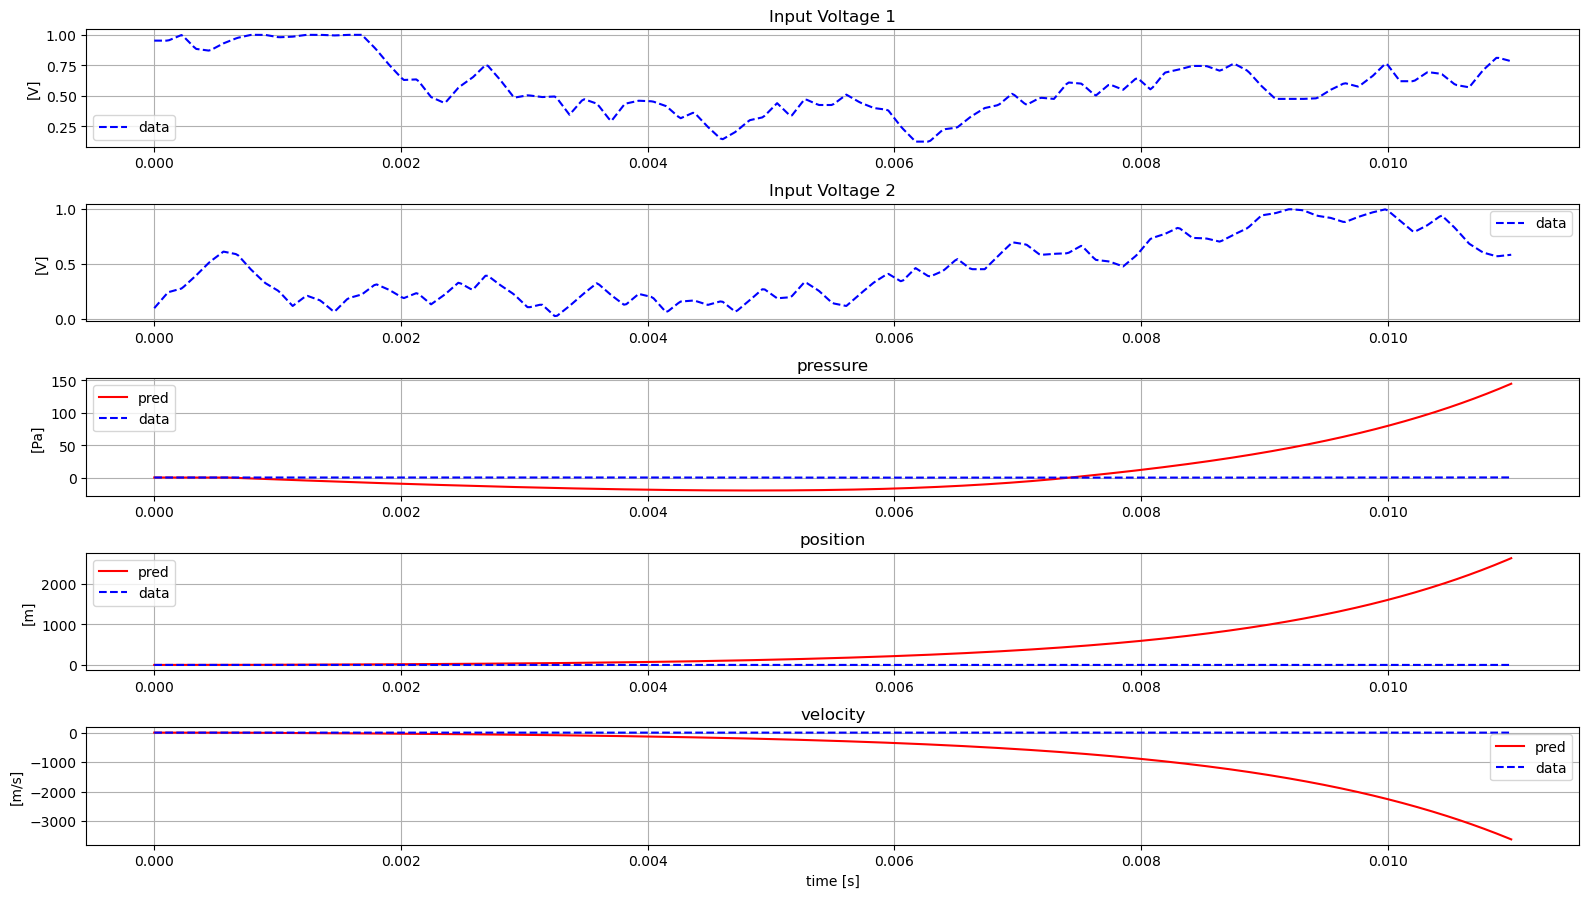

  2%|▏         | 2/100 [00:07<06:29,  3.97s/it]

Average error over full trajectories: training data TCN: 676749.1224714092


  3%|▎         | 3/100 [00:10<05:48,  3.60s/it]

Training error :  4300.955345458975
Training error :  3449.333235826364


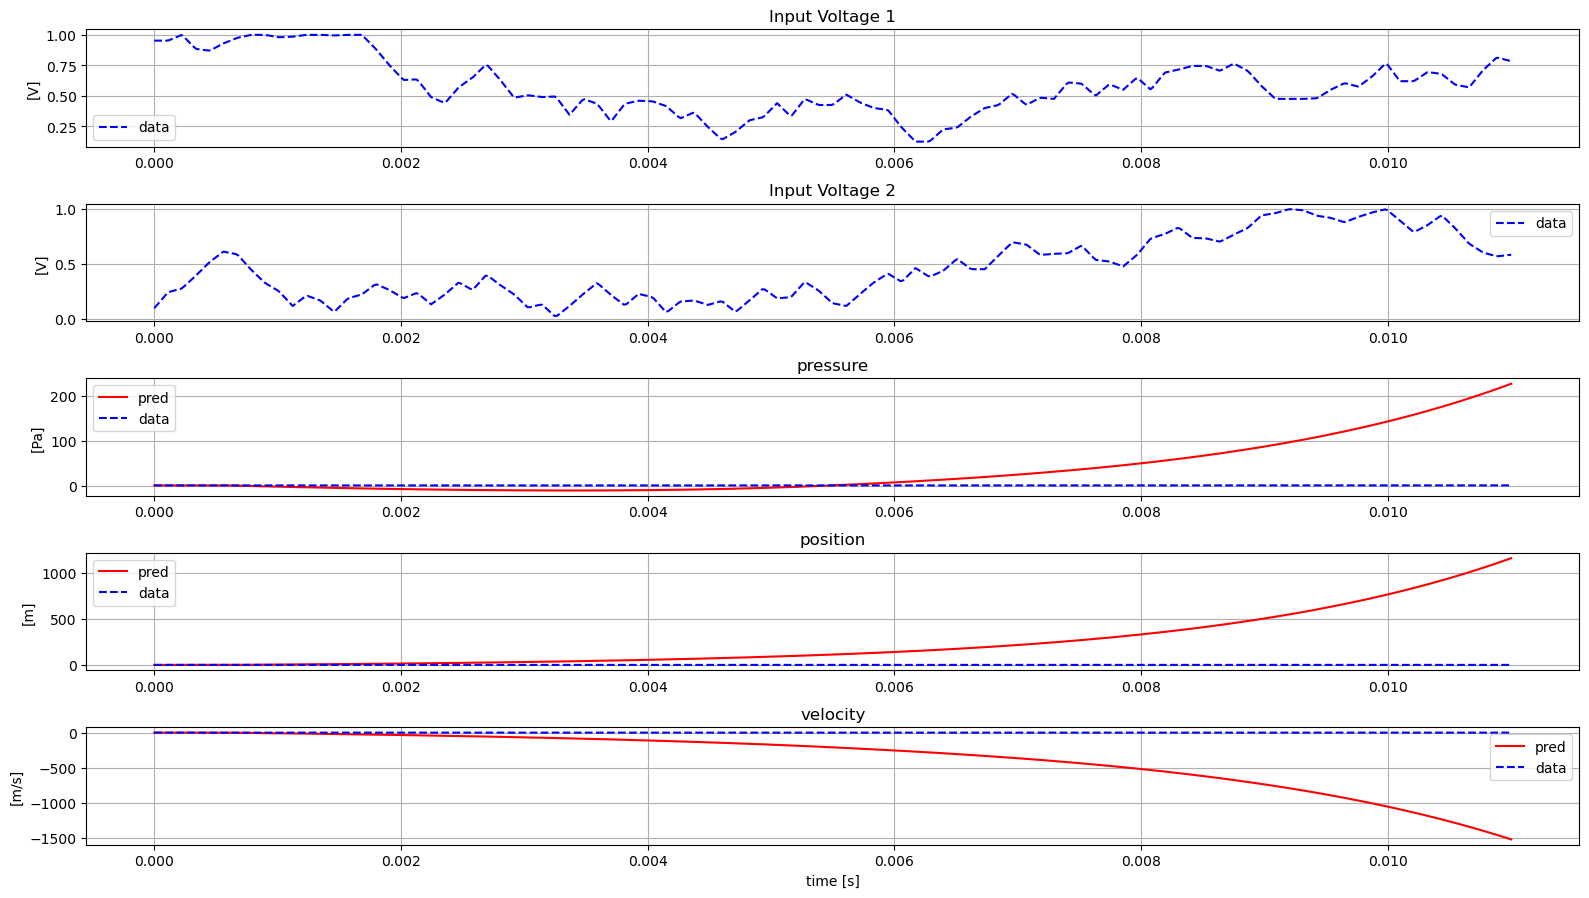

  4%|▍         | 4/100 [00:15<06:37,  4.14s/it]

Average error over full trajectories: training data TCN: 156329.3496021924


  5%|▌         | 5/100 [00:19<06:20,  4.00s/it]

Training error :  2821.8393383327557
Training error :  2351.506039336792


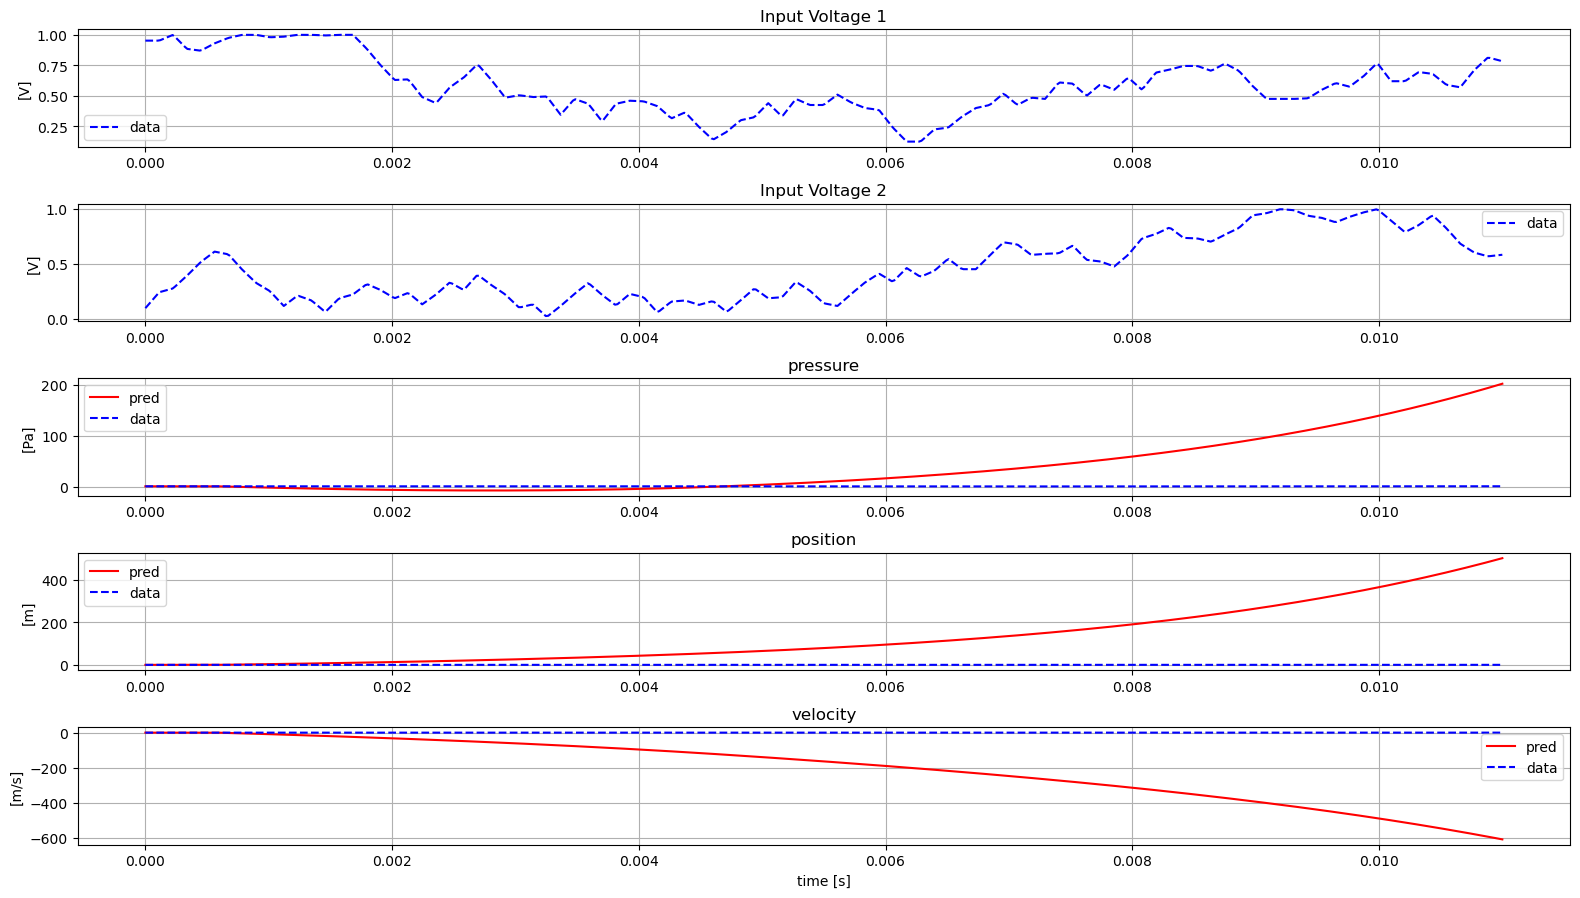

  6%|▌         | 6/100 [00:24<06:42,  4.29s/it]

Average error over full trajectories: training data TCN: 39576.5178409367


  7%|▋         | 7/100 [00:27<06:13,  4.02s/it]

Training error :  1992.4801072664582
Training error :  1710.0002714540915


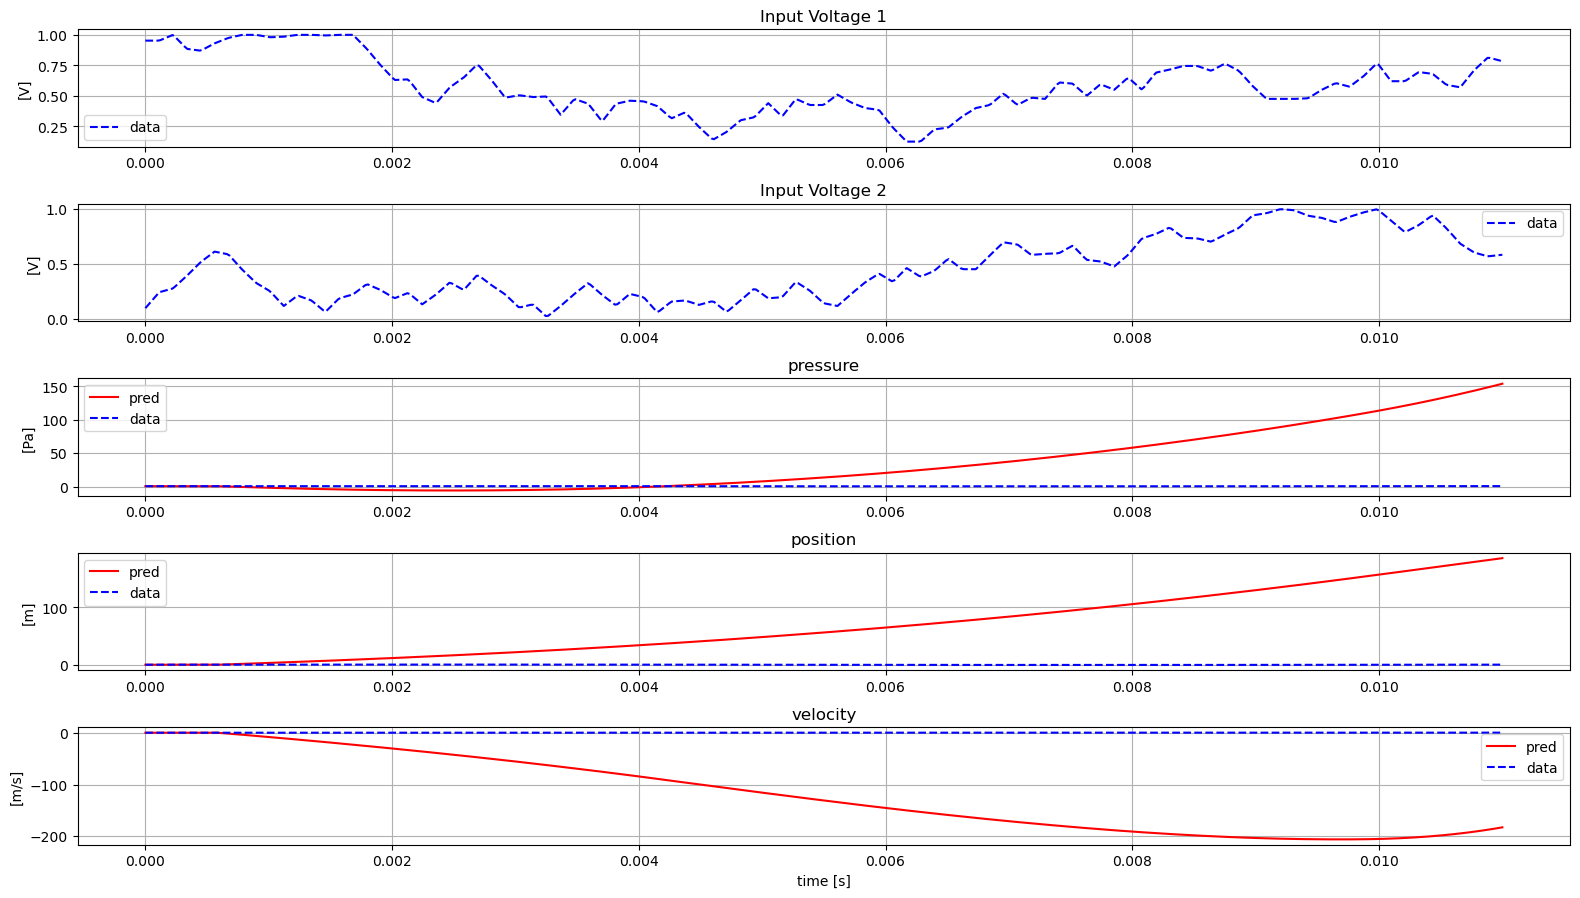

  8%|▊         | 8/100 [00:33<06:47,  4.43s/it]

Average error over full trajectories: training data TCN: 10688.770603924173


  9%|▉         | 9/100 [00:37<06:30,  4.29s/it]

Training error :  1482.562294803032
Training error :  1296.0686359809893


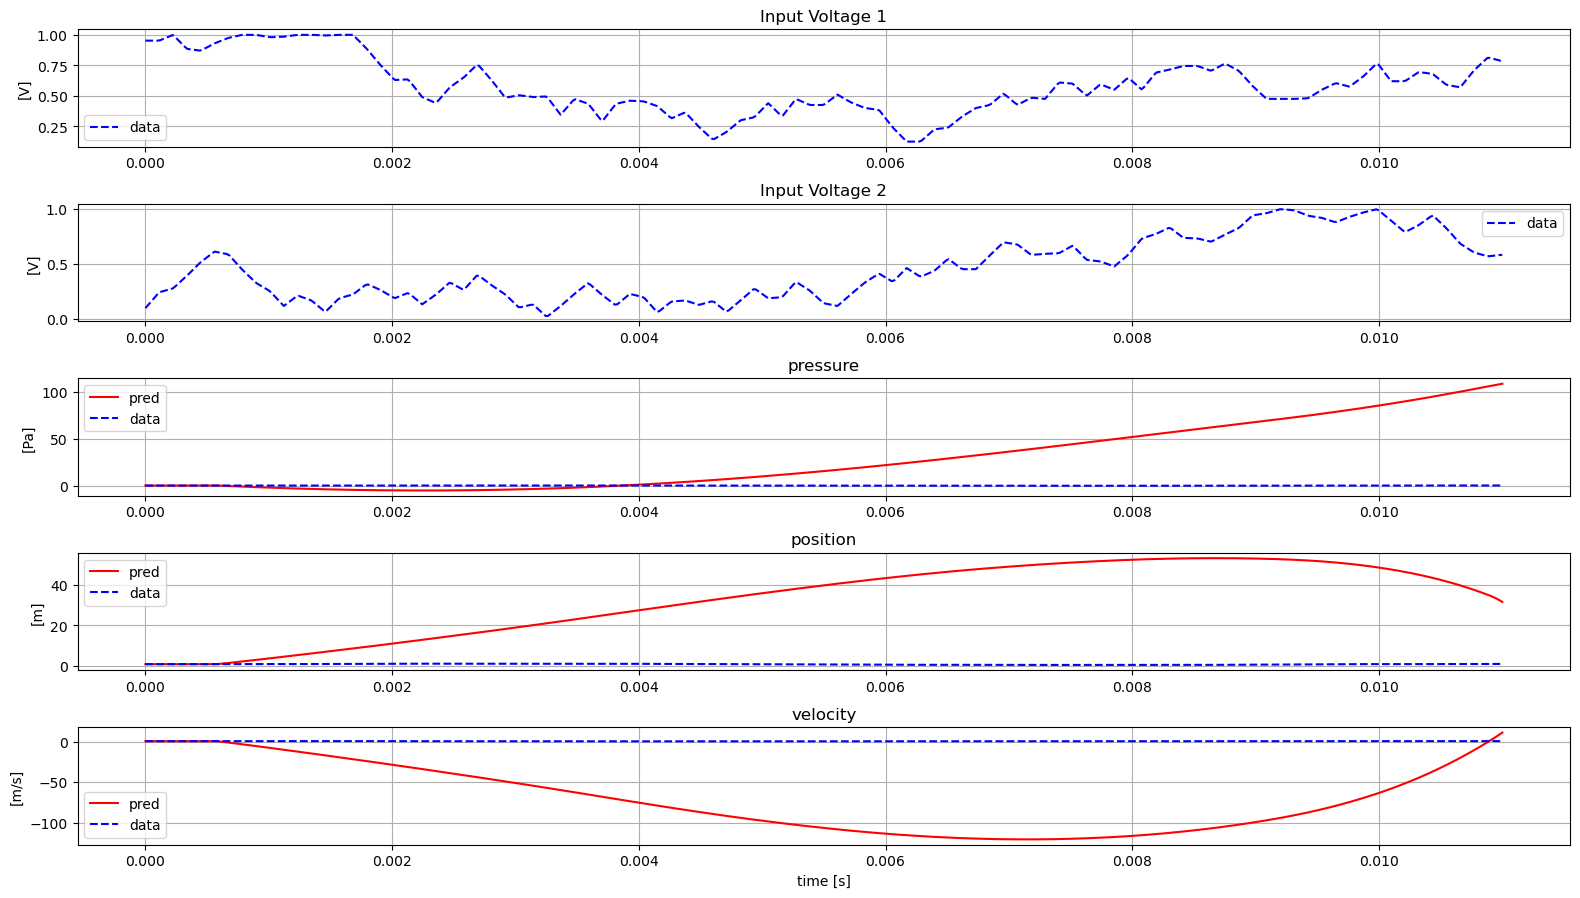

 10%|█         | 10/100 [00:44<07:42,  5.14s/it]

Average error over full trajectories: training data TCN: 3557.5466857604706


 11%|█         | 11/100 [00:48<07:08,  4.82s/it]

Training error :  1009.9978209163556


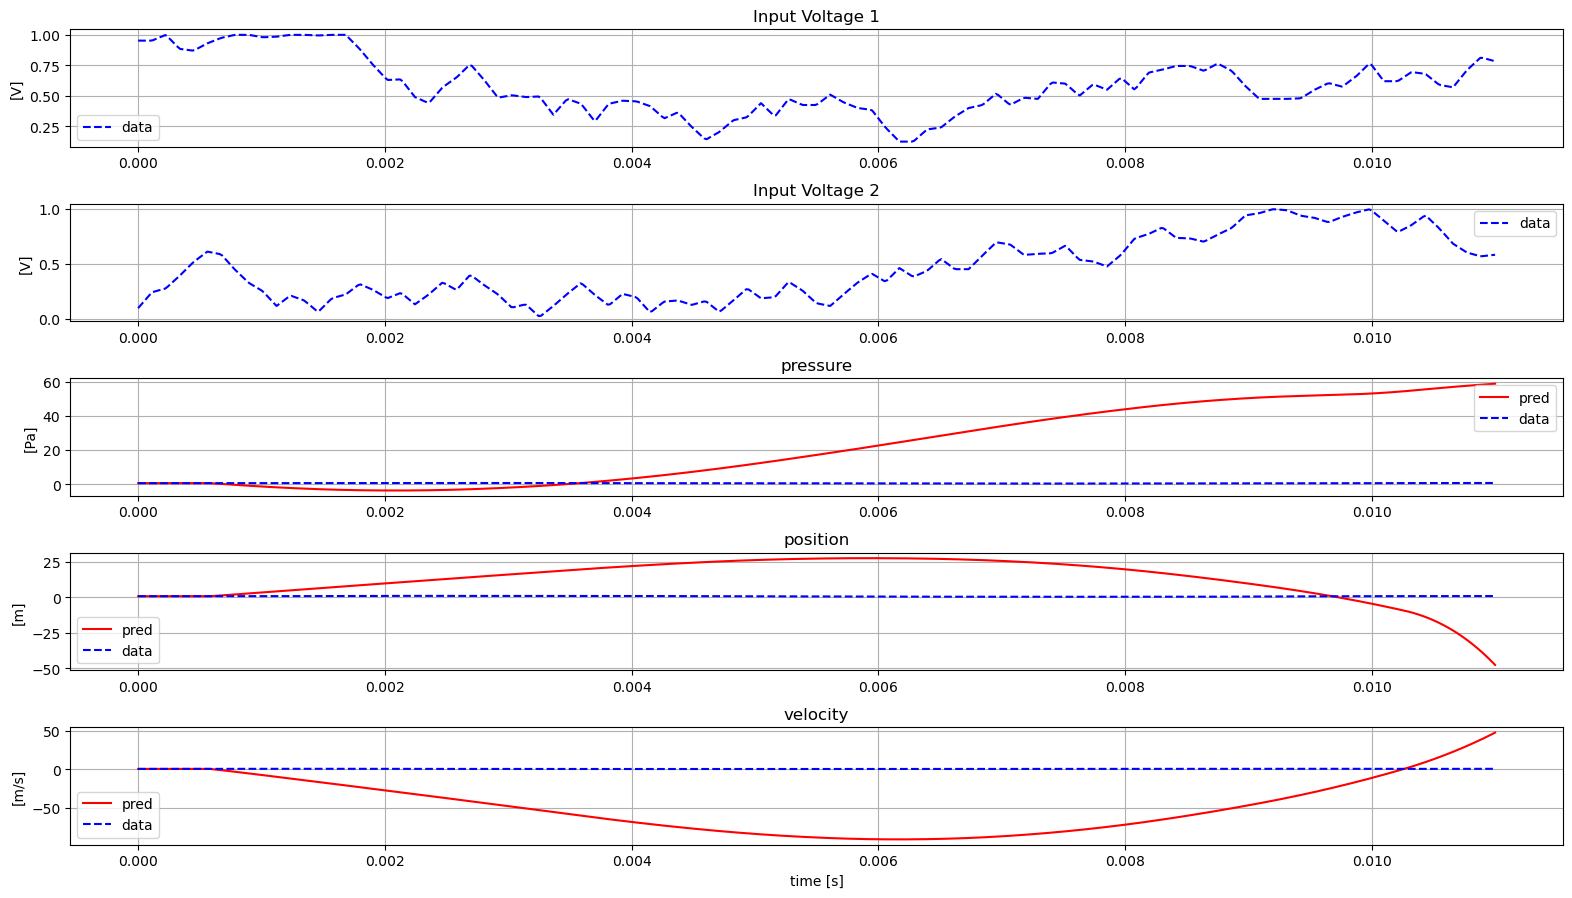

 12%|█▏        | 12/100 [00:53<07:24,  5.05s/it]

Average error over full trajectories: training data TCN: 1698.715282734654


 13%|█▎        | 13/100 [00:57<06:35,  4.54s/it]

Training error :  899.5560749592653
Training error :  804.5195236881028


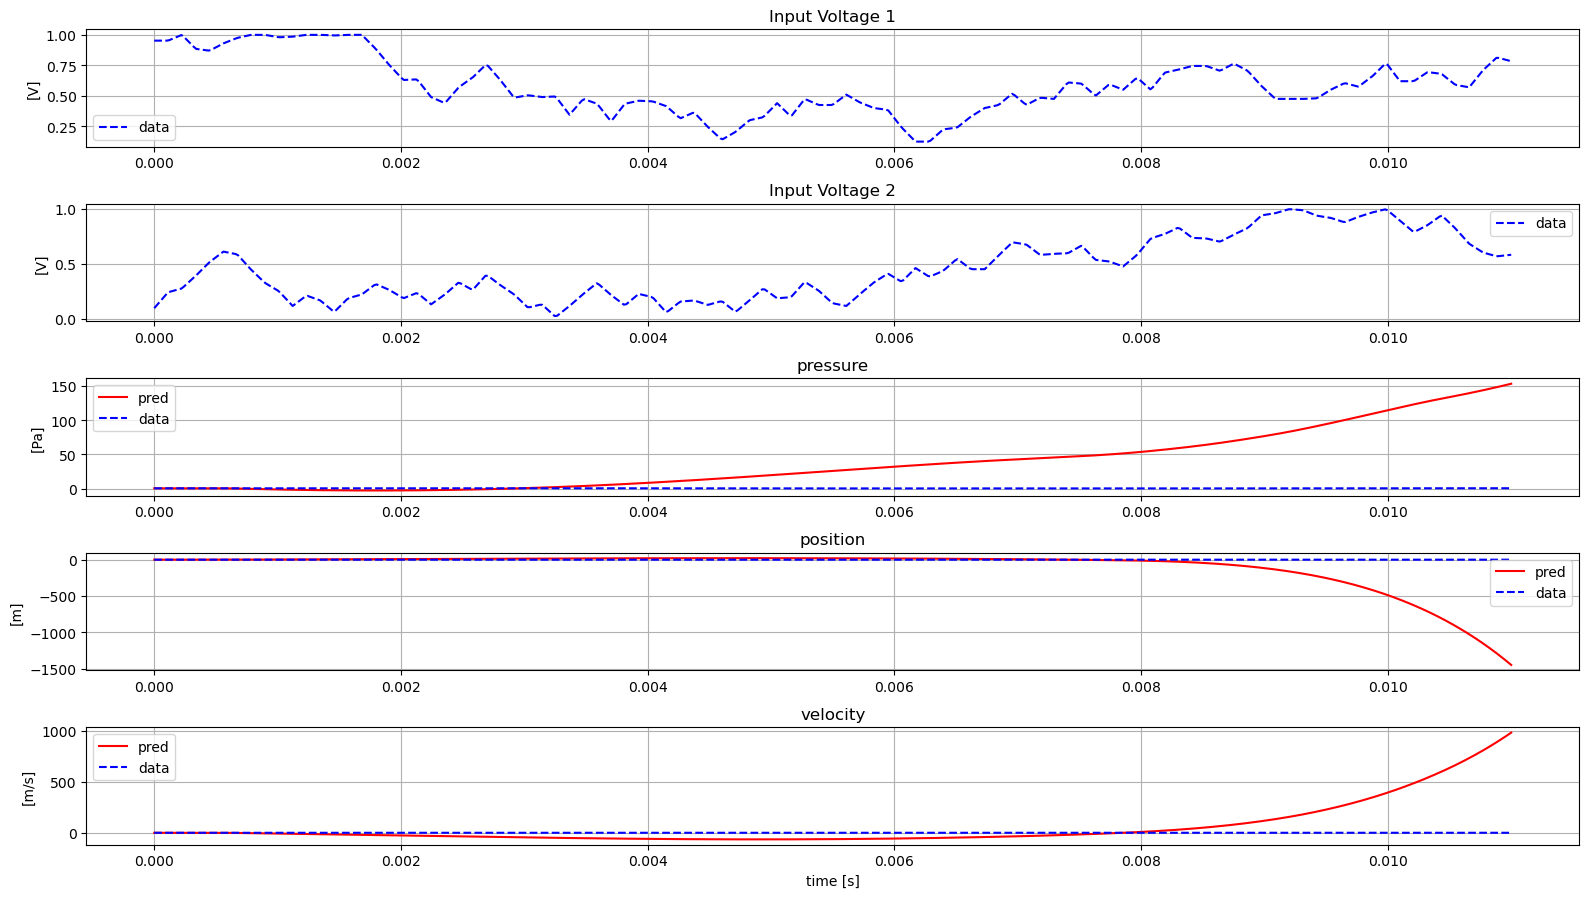

 14%|█▍        | 14/100 [01:05<08:01,  5.60s/it]

Average error over full trajectories: training data TCN: 50476.51603018244


 15%|█▌        | 15/100 [01:09<07:09,  5.05s/it]

Training error :  698.8131073837752
Training error :  581.284694560621


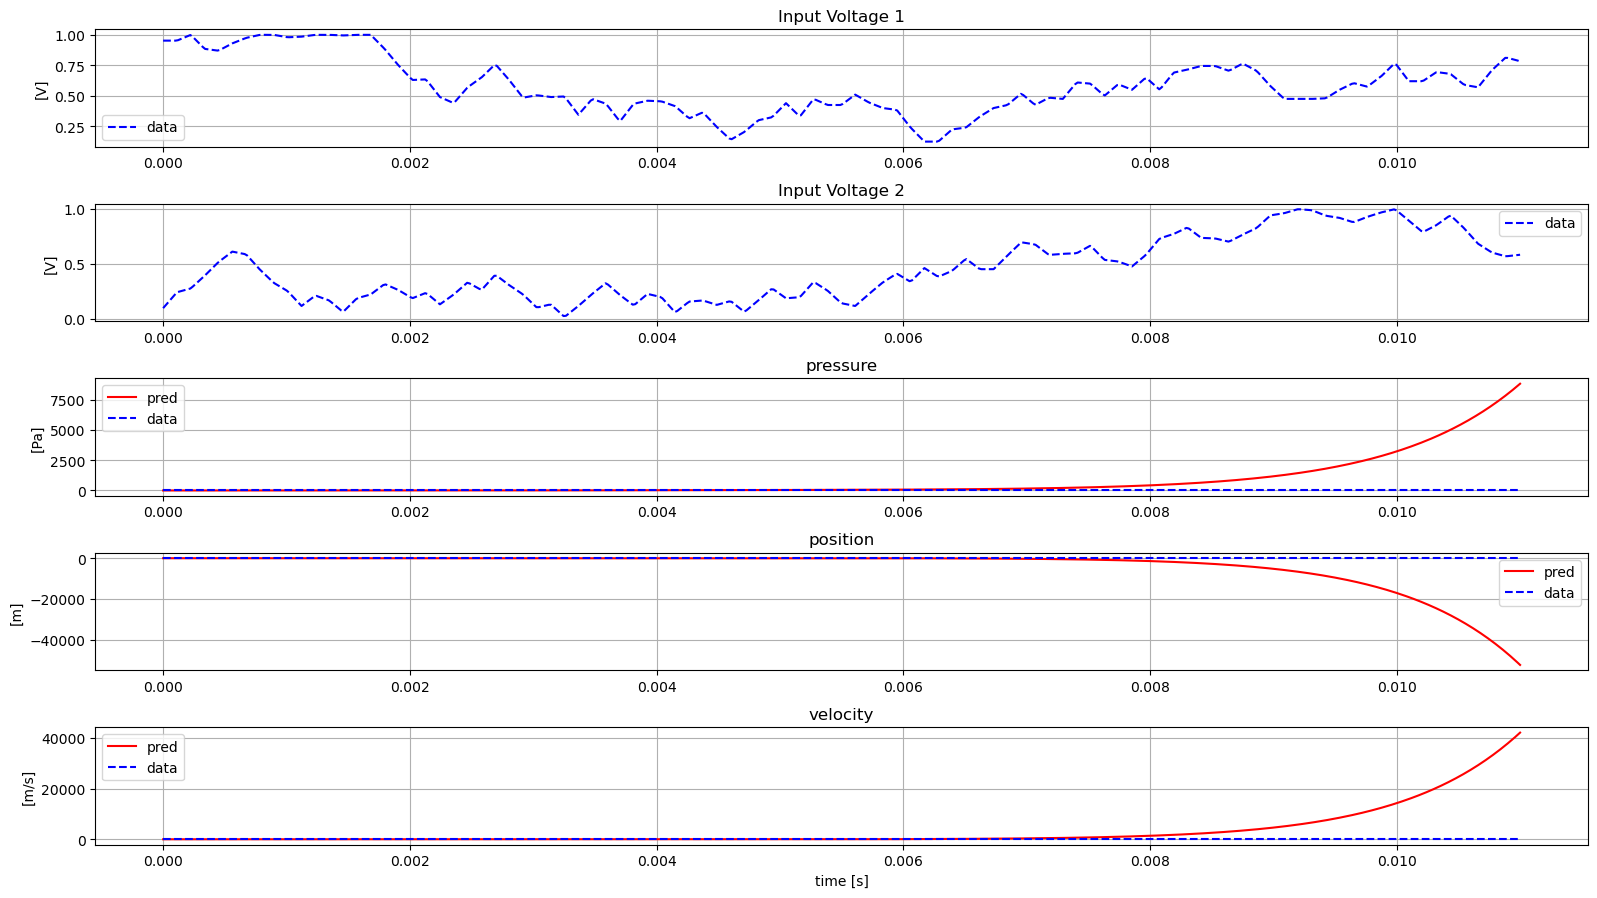

 16%|█▌        | 16/100 [01:16<07:57,  5.69s/it]

Average error over full trajectories: training data TCN: 68268051.18587431


 17%|█▋        | 17/100 [01:20<07:06,  5.14s/it]

Training error :  470.96884965754305


 17%|█▋        | 17/100 [01:20<06:32,  4.72s/it]


KeyboardInterrupt: 

In [20]:
# main (set parameters, logging, save model) 

params_tcn =    {
                        "window_size" : 30,
                        "learning_rate" : 0.001,
                        "batch_size" : 20,
                        "percentage_of_data" : 0.9,
                        "cut_off_timesteps" : 300,
                        "part_of_data" : 10,
                        "epochs" : 100,
                        "test_every_epochs" : 2,

                        "kernel_size" : 7,
                        "dropout" : 0,
                        "n_hidden" : 5,
                        "levels" : 4,
                        "input_channels" : 5,
                        "output" : 3
                    }

# Configure logging
log_file = 'training_fullsystem.log'
filemode = 'a' if os.path.exists(log_file) else 'w'
logging.basicConfig(filename=log_file, filemode=filemode, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize the TCN model
input_channels = params_tcn["input_channels"]
output = params_tcn["output"]
num_channels = [params_tcn["n_hidden"]] * params_tcn["levels"]
kernel_size = params_tcn["kernel_size"]
dropout = params_tcn["dropout"]
model_tcn = OR_TCN(input_channels, output, num_channels, kernel_size=kernel_size, dropout=dropout, windowsize=params_tcn["window_size"]).to(device)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data1 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_100.csv", num_inits=params_tcn["part_of_data"])
input_data2 = get_data(path = r"C:\Users\strasserp\Documents\ventil_lstm\data_fs\training_data_full_system_randomwalks.csv", num_inits=params_tcn["part_of_data"])

input_data = torch.cat((input_data1, input_data2))
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params_tcn["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
train_data = input_data[train_inits,:input_data.size(dim=1)-params_tcn["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set_tcn = custom_simple_dataset(train_data, window_size=params_tcn["window_size"])
train_loader_tcn = DataLoader(train_set_tcn, batch_size=params_tcn["batch_size"], pin_memory=True)

average_traj_err_train_tcn = []

#Training loop
for e in tqdm(range(params_tcn["epochs"])):
    
    train_error = train_tcn(train_loader_tcn, model_tcn, learning_rate= params_tcn["learning_rate"])
    if e % 10:
        print("Training error : ", train_error)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%params_tcn["test_every_epochs"] == 0:
        err_test_tcn = test(test_data.to(device), model_tcn, window_size=params_tcn["window_size"], display_plots=True, numb_of_inits = 1)
        average_traj_err_train_tcn.append(err_test_tcn)
        print(f"Average error over full trajectories: training data TCN: {err_test_tcn}")
        
# Save trained model
path_tcn = f'or_tcn.pth'

torch.save(model_tcn.state_dict(), path_tcn)

print(f"Run finished!")

# Log parameters

logging.info(f"hyperparams tcn: {params_tcn}")
logging.info(f"TCN {average_traj_err_train_tcn}")   
logging.info("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
logging.info("\n")
